# Import Libraries

In [22]:
import os
import sys

util_path = os.path.abspath(os.path.join('..'))

if util_path not in sys.path:
    sys.path.append(util_path)

import utility_func as util
import importlib
importlib.reload(util)

<module 'utility_func' from 'D:\\GitUpload\\Blue-Text-Extraction\\utility_func.py'>

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Load Images

In [3]:
curr_dir = (os.getcwd()).replace('\\', '/')
img_path = (os.path.join(curr_dir, 'Data')).replace('\\', '/')

In [10]:
image = util.cv2.imread(img_path + '/image 21.jpg')

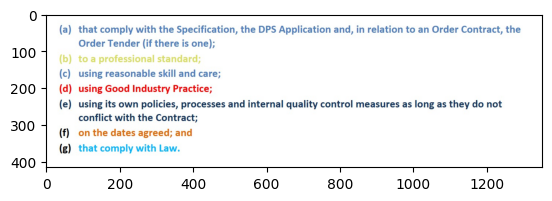

In [11]:
util.plt.imshow(util.cv2.cvtColor(image, util.cv2.COLOR_BGR2RGB))

In [33]:
hand_wrt_image = util.cv2.imread(img_path + '/image 10.jpg')

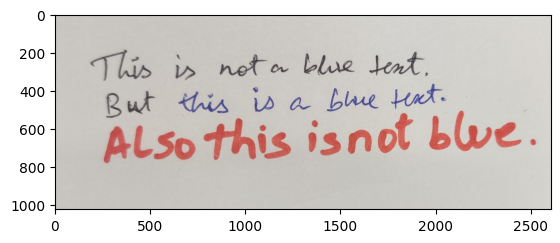

In [34]:
util.plt.imshow(util.cv2.cvtColor(hand_wrt_image, util.cv2.COLOR_BGR2RGB))

# Blue Text Filtering

In [32]:
def extract_blue_text(image):
    
    hsv_image = util.cv2.cvtColor(image, util.cv2.COLOR_BGR2HSV)
    rgb_image = util.cv2.cvtColor(image, util.cv2.COLOR_BGR2RGB)
    v = hsv_image[:, :, 2]

    mean_v = util.np.mean(v)
    is_wht_bkgrnd = mean_v > 200

    # For white background
    if is_wht_bkgrnd:
        blue_low = util.np.array([90, 50, 50])
        blue_uppr = util.np.array([140, 255, 255])
        mask = mask = util.cv2.inRange(hsv_image, blue_low, blue_uppr)
    # For darker background or shaded background
    else:
        b, g, r = util.cv2.split(image)
        equalize_b = util.cv2.equalizeHist(b)
        equalize_image = util.cv2.merge([equalize_b, g, r])

        hsv_image = util.cv2.cvtColor(equalize_image, util.cv2.COLOR_BGR2HSV)

        blur_image = util.cv2.GaussianBlur(hsv_image, (5, 5), 0)

        blue_low = util.np.array([90, 20, 20])
        blue_uppr = util.np.array([140, 255, 255])
        mask = mask = util.cv2.inRange(blur_image, blue_low, blue_uppr)

    blue_regions = util.cv2.bitwise_and(image, image, mask=mask)
    blue_regions_rgb = util.cv2.cvtColor(blue_regions, util.cv2.COLOR_BGR2RGB)
    pil_image = util.Image.fromarray(blue_regions_rgb)
    
    util.plt.imshow(blue_regions_rgb)

    return pil_image

## For pdf/doc text

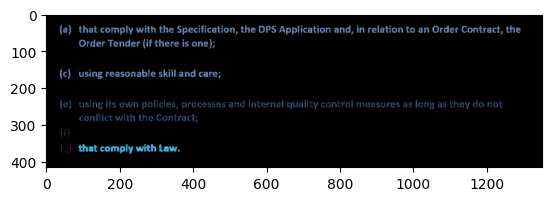

In [13]:
pil_image = extract_blue_text(image)

In [18]:
pil_image.save(img_path + '/filtered_image.jpg')

## For hand written text

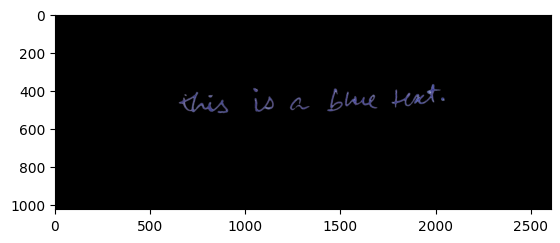

In [35]:
pil_image_hnd_wrt = extract_blue_text(hand_wrt_image)

In [41]:
pil_image_hnd_wrt.save(img_path + '/hnd_wrt_filtered_image.jpg')

# Text Extraction

In [8]:
tokenizer = util.AutoTokenizer.from_pretrained('ucaslcl/GOT-OCR2_0', trust_remote_code=True)
model = util.AutoModel.from_pretrained('ucaslcl/GOT-OCR2_0', trust_remote_code=True, low_cpu_mem_usage=True, 
                                       device_map='cuda', use_safetensors=True, pad_token_id=tokenizer.eos_token_id)
model = model.eval().cuda()

generation_config.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

## For pdf/doc file text

In [19]:
res = model.chat(tokenizer, img_path + '/filtered_image.jpg', ocr_type='ocr')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
`get_max_cache()` is deprecated for all Cache classes. Use `get_max_cache_shape()` instead. Calling `get_max_cache()` will raise error from v4.48


In [42]:
print(f'Extracted text: \n{res}')

Extracted text: 
( a) that comply with the Specification, the DPS Application and, in relation to an Order Contract, the Order Tender( if there is one) ;  ( c) using reasonable skill and care;  ( e) using its own policies, processes and internal quality control measures as long as they do not conflict with the Contract;  that comply with Law.


## For hand written text

In [43]:
res_hnd_wrt = model.chat(tokenizer, img_path + '/hnd_wrt_filtered_image.jpg', ocr_type='ocr')
print(f'Extracted text: \n{res_hnd_wrt}')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Extracted text: 
this ioa blue Hn t.


# Calculating Accuracy of the model

In [30]:
def calculate_metrics(original_text, extracted_text):
    # Calculate Levenshtein distance
    levenshtein_distance = util.Levenshtein.distance(original_text, extracted_text)

    # Calculating word error rate
    original_words = original_text.split()
    extracted_words = extracted_text.split()
    word_errors = util.Levenshtein.distance(" ".join(original_words), " ".join(extracted_words))
    wer = word_errors / len(original_words) if len(original_words) > 0 else 0

    print(f'The Levenshtein distance is {levenshtein_distance}')
    print(f'The Word Error Rate is {wer}')

## For pdf/doc file text

In [31]:
original_text = '''(a) that comply with the Specification, the DPS Application and, in relation to an Order Contract, the Order Tender (if there is one);
(c) using reasonable skill and care;
(e) using its own policies, processes and internal quality control measures as long as they do not conflict with the Contract;
(g) that comply with Law.  '''

calculate_metrics(original_text, res)

The Levenshtein distance is 16
The Word Error Rate is 0.18181818181818182


## For hand written text

In [44]:
original_text_hnd_wrt = 'this is a blue text.'

calculate_metrics(original_text_hnd_wrt, res_hnd_wrt)

The Levenshtein distance is 5
The Word Error Rate is 1.0


In [45]:
util.torch.hub._remove_all()

AttributeError: module 'torch.hub' has no attribute '_remove_all'